In [40]:
import pandas as pd
import collections
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.feature_extraction.text import CountVectorizer
import glob
from pythia.api import hdm_market
from pythia.features.target_creator import target_creator
from pythia.model_selection.split import PurgedKFold, TemporalKFold
from pythia.viz.split import plot_splits
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nlp_algo import Nlp_algo
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

## News

In [2]:
words = set(nltk.corpus.words.words())
def remove_non_english_words(text, words):
    filtered_text = " ".join(w for w in nltk.wordpunct_tokenize(text) \
             if w.lower() in words or not w.isalpha())
    return filtered_text

### Examples

- *HSBC*: BBG000BBZW12
- *Nike*: BBG000C5HS04


In [3]:
i = 0
data = {}
for file in glob.glob('news/*'):
    date = file.split('_')[0].split('/')[1]
    bbg_id = file.split('_')[1]
    uuid = file.split('_')[2].split('.')[0]
    
    f = open(file,'r')
    text = f.read()
    f.close()
    
    if bbg_id == 'BBG000C5HS04':
        data[i] = {"date" : date, 
                   "bbg_id" : bbg_id,
                   "uuid" : uuid,
                   "text" : remove_non_english_words(text, words)}
        i+=1
#     if i > 1000:
#         break

In [4]:
len(list(data.keys()))

191

In [5]:
df = pd.DataFrame.from_records(data).T
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.shape

(191, 4)

## Market data


In [7]:
mapping_table = pd.read_csv('tickers_mapping.csv')[['HdMTicker', 'FigiID']]

In [8]:
df = df.merge(mapping_table, how='left', left_on = 'bbg_id', right_on='FigiID')

In [9]:
#drop bbg_id without a HdM ticker
df = df[~df['HdMTicker'].isna()]

In [10]:
df['bbg_id'].nunique()

1

In [11]:
df.shape

(191, 6)

In [12]:
username = "quant_user"
password = "iuosdHJK7891hjk3B?NskjhUYIn#jk*sd"

hdmApi = hdm_market.HdmMarket(username,password)

In [13]:
print(list(df['HdMTicker'].unique()))

['NKE:US']


In [14]:

market_data = hdmApi.request_data(
    list_ticker = list(df['HdMTicker'].unique()),
    start_date='2019-01-01',
    end_date='2020-03-01',
)

/home/badrg/Projects/pythia/api/base.py:207: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead

/home/badrg/Projects/pythia/api/hdm_market.py:199: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [15]:
market_data = market_data[['open']]

In [16]:
# datelist = pd.date_range(start='2019-01-01', end=pd.datetime.today()).tolist()


In [17]:
# market_data = pd.DataFrame(index= datelist,
#                            columns=df['HdMTicker'].unique(),
#                            data = np.random.randn(len(datelist), len(df['HdMTicker'].unique())))

# market_data = np.random.randint(100, size=(1,market_data.shape[1])) + market_data.cumsum()
# market_data = market_data.stack().to_frame()

In [18]:
# market_data.reset_index(inplace=True)
# market_data.columns = ['date','ticker','open']

In [19]:
# market_data.set_index(['ticker', 'date'], inplace=True)

In [20]:
print('Building target ...')

target_creator_dict = {
    "fwd_return": {
        "return_type": ['open_open'],
        "return_shift": [1]
    }
}

target = target_creator(market_data, target_creator_dict).compute()

Building target ...


In [21]:
target.head()

trgt__fwdreturn__return_shift_1__return_type_open_open
ticker date                                                              
NKE:US 2019-01-02                                           0.006299     
       2019-01-03                                           0.002727     
       2019-01-04                                           0.017411     
       2019-01-07                                           0.027579     
       2019-01-08                                           0.001821

In [22]:
target.columns = ['r_t+1_t']
target.reset_index(inplace=True)


In [23]:
df = df.merge(target, how='left', left_on= ['date', 'HdMTicker'], right_on = ['date', 'ticker'] )
# df['r_t+2_t+1'] = df['r_t+1_t'].shift(-1)
# df['r_t_t-1'] = df['r_t+1_t'].shift(1)

In [24]:
df.columns = ['date', 'bbg_id', 'uuid', 'text', 'HdMTicker', 'FigiID', 'ticker',
       'return']

In [25]:
# #TODO: reset index 000 ... drop
# df = pd.concat([df[['bbg_id', 'date', 'text', 'uuid', 'HdMTicker', 'FigiID', 'ticker', 'r_t+1_t']],
# df[['bbg_id', 'date', 'text', 'uuid', 'HdMTicker', 'FigiID', 'ticker', 'r_t+2_t+1']],
# df[['bbg_id', 'date', 'text', 'uuid', 'HdMTicker', 'FigiID', 'ticker', 'r_t_t-1']]], axis=0)

# df['return'] = df[['r_t+1_t', 'r_t+2_t+1', 'r_t_t-1']].fillna(0).sum(axis=1)

In [26]:
# df.drop(['r_t+1_t', 'r_t+2_t+1', 'r_t_t-1'], axis=1, inplace=True)

In [27]:
df.shape

(191, 8)

### Load BBG_ID <> Ticker name table

# Generate Data

In [28]:
# text1 = '''But now there is evidence on six continents of sustained transmission of the virus, which has infected more than 120,000 people and killed more than 4,300, and by most scientific measures the spread qualifies as a pandemic. The designation itself is largely symbolic, but public health officials know that the public will hear in the word elements of danger and risk.'''
# text2 = '''The committee hearing quickly devolved into a partisan fight over the Trump administration’s response to the coronavirus outbreak, with Democrats ripping into top health officials and Republicans defending President Trump'''
# text3 = '''Until now, the W.H.O. had avoided using the term to describe the epidemic leapfrogging across the world, for fear of giving the impression that it was unstoppable and countries would give up on trying to contain it. The organization had said earlier in the outbreak that it no longer officially declared when an epidemic reaches pandemic proportions, preferring instead to declare global public health emergencies.'''
# text4 = '''The spread of the coronavirus across more than 100 countries now qualifies as a global pandemic, World Health Organization officials said on Wednesday, confirming what many epidemiologists have been saying for weeks.'''
# data = {1: {'text': text1, "return" : 0.8},
#         2:{'text':text2, "return": -0.2}, 
#         3:{'text':text3, "return": 0.5},
#         4:{'text':text4, "return":-0.4}
#        }

# Clean Textual Data


- Stemming: TODO
- Stop Words: OK 
- English words: OK
- ... 



# Step 1: Remove neutral words

S1. For each word $1 \leq j \leq m,$ let
$f_{j}=\frac{\# \text { articles including word } j \text { AND having } \operatorname{sgn}(y)=1}{\# \text { articles including word } j}$


S2. For a proper threshold $\alpha_{+}>0, \alpha_{-}>0,$ and $\kappa>0$ to be determined, construct
$$
\widehat{S}=\left\{j: f_{j} \geq 1 / 2+\alpha_{+}\right\} \cup\left\{j: f_{j} \leq 1 / 2-\alpha_{-}\right\} \cap\left\{j: k_{j} \geq \kappa\right\}
$$
where $k_{j}$ is the total count of articles in which word $j$ appears.

# Step2: Learning Sentiment Topic


S1. Sort the returns $\left\{y_{i}\right\}_{i=1}^{n}$ in ascending order. For each $1 \leq i \leq n,$ let
$$
\widehat{p}_{i}=\frac{\text { rank of } y_{i} \text { in all returns }}{n}
$$
S2. For $1 \leq i \leq n,$ let $\widehat{s}_{i}$ be the total counts of words from $\widehat{S}$ in article $i,$ and let $\hat{d}_{i}=\widehat{s}_{i}^{-1} d_{i,[\widehat{S}]}$ Write $\widehat{D}=\left[\widehat{d}_{1}, \widehat{d}_{2}, \ldots, \widehat{d}_{n}\right] .$ Construct
$$
\widehat{O}=\widehat{D} \widehat{W}^{\prime}\left(\widehat{W} \widehat{W}^{\prime}\right)^{-1}, \quad \text { where } \quad \widehat{W}=\left[\begin{array}{cccc}
\widehat{p}_{1} & \widehat{p}_{2} & \cdots & \widehat{p}_{n} \\
1-\widehat{p}_{1} & 1-\widehat{p}_{2} & \cdots & 1-\widehat{p}_{n}
\end{array}\right]
$$
Set negative entries of $\widehat{O}$ to zero and re-normalize each column to have a unit $\ell^{1}$ -norm. We use the same notation $\widehat{O}$ for the resulting matrix. We also use $\widehat{O}_{\pm}$ to denote the two columns of $\widehat{O}=\left[\widehat{O}_{+}, \widehat{O}_{-}\right]$

# Step3: Compute pi for a new document 

S1. Let $\widehat{s}$ be the total count of words from $\widehat{S}$ in the new article. Obtain $\widehat{p}$ by
$$
\widehat{p}=\arg \max _{p \in[0,1]}\left\{\widetilde{s}^{-1} \sum_{j=1}^{\hat{s}} d_{j} \log \left(p \widehat{O}_{+, j}+(1-p) \widehat{O}_{-, j}\right)+\lambda \log (p(1-p))\right\}
$$
where $d_{j}, \widehat{O}_{+, j},$ and $\widehat{O}_{-, j}$ are the $j$ th entries of the corresponding vectors, and $\lambda>0$ is a tuning parameter.

### Fitting/ Predict

In [29]:
nlpa = Nlp_algo(alpha_plus= 0.3, alpha_minus= 0.3, kappa=10, lambda_reg=1)


In [30]:
nlpa.fit(df.fillna(0))

NON RARE:  Index(['ability', 'able', 'abroad', 'absolutely', 'abuse', 'aby', 'access',
       'according', 'accused', 'acting',
       ...
       'xi', 'y', 'yard', 'year', 'york', 'young', 'youth', 'z', 'zero',
       'zoom'],
      dtype='object', length=1382)


In [31]:
nlpa._O_hat_df

,keeping,thinner,notoriety,headquarters,strong,quick,conviction,primary,defendant,jordan,...,risk,shakedown,pointed,hired,majority,supply,linked,relationship,maker,blow
pos,0.005789,0.000000,0.002075,0.000000,0.005218,0.002717,0.002929,0.000216,0.012490,0.035564,...,0.004921,0.001747,0.001751,0.015077,0.002183,0.000000,0.000000,0.003139,0.001546,0.000000
neg,0.001591,0.004536,0.006784,0.006192,0.003921,0.000000,0.001578,0.003576,0.004335,0.000000,...,0.002165,0.003430,0.002266,0.013041,0.000914,0.006798,0.009394,0.007459,0.004221,0.004239


In [32]:
nlpa._O_hat_df.loc['pos'].sort_values(ascending=False)[:50].head(10)

unveiled     0.056745
mention      0.039636
jordan       0.035564
encounter    0.030058
obvious      0.024803
p            0.024270
southern     0.023275
unless       0.022032
relevant     0.021808
killing      0.019741
Name: pos, dtype: float64

In [33]:
nlpa._O_hat_df.loc['neg'].sort_values(ascending=False)[:50].head(10)

pence      0.027965
change     0.026657
unless     0.023542
rape       0.021573
global     0.021570
data       0.019975
track      0.018665
wake       0.017490
verdict    0.016046
climate    0.015728
Name: neg, dtype: float64

In [34]:
# text1 = '''If you have traveled from an affected area, there may be restrictions on your movements for up to 2 weeks. If you develop symptoms during that period (fever, cough, trouble breathing), seek medical advice. Call the office of your health care provider before you go, and tell them about your travel and your symptoms. They will give you instructions on how to get care without exposing other people to your illness. While sick, avoid contact with people, don’t go out and delay any travel to reduce the possibility of spreading illness to others.'''
# new_data = {1: {'text': text1}}
# new_data = pd.DataFrame.from_records(new_data).T

In [35]:
# nlpa.predict(new_data)

In [36]:
# nlpa._opt_res

Preparing topics plots ... 


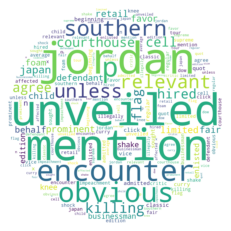

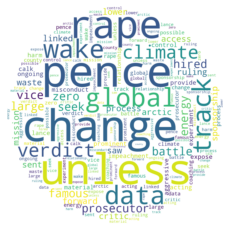

In [37]:
nlpa.plot_topics(50)

# Next steps

**Next steps**

- Train using Temporal CV
    - plot important topics with time 
- Build strategies


**Other ideas from the paper** 

- Fresh news 
- Time for the news to be considered by the market 
    
    

## Code helper

In [38]:
# virus_mask = ['coronavirus' in x for x in  df['text']]
# df.loc[virus_mask,['text']]

In [39]:

# nlpa = Nlp_algo(alpha_plus= 0.2, alpha_minus= 0.2, kappa=10, lambda_reg=1)
# nlpa._compute_word_count(df_feb.fillna(0))
# nlpa.word_count_df['epidemic'][nlpa.word_count_df['epidemic'] != 0 ]
# nlpa._fj_vector = nlpa._compute_fj()
# mask_rare = nlpa.word_count_df.sum() > 10
# mask_common = nlpa.word_count_df.sum() < 5000
# nlpa.word_count_df.sum()[ (mask_rare) & (mask_common) ].hist(bins=100, )
# nlpa._fj_vector.hist()
# nlpa._fj_vector = nlpa._compute_fj()
# nlpa._get_non_neutral_words()
# nlpa._fj_vector.hist(bins=20)
# nlpa._fj_vector = nlpa._compute_fj()
# nlpa._get_non_neutral_words()
